# Setup library

In [1]:
#Cài đặt thư viện
!pip install transformer
!pip install underthesea
!pip install torch
!pip install scikit-learn

#Import thư viện
import numpy as np
import torch
import underthesea
from transformers import AutoModel, AutoTokenizer

ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.2 MB/s eta 0:00:00


# Download model

In [2]:
#Tải phoBert model and tokenizer từ Hugging Face
v_phobert = AutoModel.from_pretrained("vinai/phobert-base")
v_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Data cleaning

In [3]:
import re
def standardize_data(row):
    row = re.sub(r"[\.,\?]+$-", "", row)
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    row = row.strip().lower()
    return row

# Define vectorization function

In [4]:
import torch
import numpy as np

def process_long_sequence(sequence, max_len=500, chunk_size=256):
    # Tokenize the sequence without adding special tokens
    tokens = v_tokenizer.encode(sequence, add_special_tokens=False)
    all_features = []
    all_attention_masks = []

    # Process the tokens in chunks of `chunk_size`
    for i in range(0, len(tokens), chunk_size):
        chunk = tokens[i:i+chunk_size]

        # Padding and attention mask for the chunk
        padded = chunk + [v_tokenizer.pad_token_id] * (chunk_size - len(chunk))
        attention_mask = [1] * len(chunk) + [0] * (chunk_size - len(chunk))

        # Convert to tensors
        padded_tensor = torch.tensor(padded).unsqueeze(0)  # Shape: (1, chunk_size)
        attention_mask_tensor = torch.tensor(attention_mask).unsqueeze(0)  # Shape: (1, chunk_size)

        # Vectorization (getting the hidden states from PhoBERT)
        with torch.no_grad():
            last_hidden_states = v_phobert(input_ids=padded_tensor, attention_mask=attention_mask_tensor)

        # Extract token embeddings for this chunk
        chunk_features = last_hidden_states.last_hidden_state[0].numpy()  # Shape: (chunk_size, hidden_size)
        chunk_attention_mask = attention_mask_tensor[0].numpy()  # Shape: (chunk_size,)

        # Exclude padding tokens
        non_pad_features = chunk_features[:len(chunk)]  # Shape: (len(chunk), hidden_size)
        non_pad_attention_mask = chunk_attention_mask[:len(chunk)]  # Shape: (len(chunk),)

        # Append to lists for later concatenation
        all_features.append(non_pad_features)
        all_attention_masks.append(non_pad_attention_mask)

    # Concatenate all chunks
    all_features = np.concatenate(all_features, axis=0)
    all_attention_masks = np.concatenate(all_attention_masks, axis=0)

    # Ensure the correct hidden size (PhoBERT hidden size is typically 768)
    hidden_size = all_features.shape[1]

    # Pad the final features and attention masks to `max_len`
    if len(all_features) < max_len:
        padded_features = np.concatenate([all_features, np.zeros((max_len - len(all_features), 768))], axis=0)
        padded_attention_masks = np.concatenate([all_attention_masks, np.zeros((max_len - len(all_attention_masks),))], axis=0)
    else:
        padded_features = all_features[:max_len]  # Truncate if needed
        padded_attention_masks = all_attention_masks[:max_len]  # Truncate if needed

    return padded_features, padded_attention_masks


# Load in train dataset

In [5]:
!pip install pandas
import pandas as pd

In [6]:
df = pd.read_csv('new_datasets.csv')
df
texts = df.iloc[:, 0].tolist()

In [7]:
texts = df.iloc[:, 0].tolist()
texts

['Hôm nay là một ngày tuyệt vời mà tôi không thể nào quên! Cuối cùng thì sau bao nhiêu ngày chuẩn bị và lo lắng mọi thứ, nhóm chúng tôi đã hoàn thành bài thuyết trình mà chúng tôi đã làm từ tuần trước. Đã có những đêm chúng tôi phải thức khuya để hoàn thiện các tài liệu, tranh luận về từng chi tiết nhỏ, và tập luyện cho phần trình bày sao cho thật mạch lạc, lôi cuốn. Mỗi người trong nhóm đều đóng góp ý tưởng, công sức của mình, và hôm nay là lúc chúng tôi đã được thấy những nỗ lực đó được đền đáp.\nKhi đứng trước lớp, tôi có thể cảm nhận rõ ràng sự hồi hộp trong lòng, nhưng đồng thời cũng cảm thấy tự tin vì tôi đã chuẩn bị kỹ lưỡng. Nhóm chúng tôi đều có mặt trên sân khấu, và khi trình bày từng phần của bài thuyết trình, chúng tôi đã cảm nhận được sự kết nối và mạch lạc giữa các thành viên. Tuy có chút lo lắng, nhưng cảm giác đó nhanh chóng được thay thế bởi niềm tin vào bản thân và vào công việc của chúng tôi.\nChà, phải nói là phản hồi từ giảng viên thật sự rất tích cực. Thầy đã khen

In [8]:
emotion = ["Happy", "Sad", "Angry", "Neutral", "Bored", "Suprise", "Anxious"]

sort_df = df.loc[~df["Emotion"].isin(emotion)]

sort_df

,Script,Vui,Buồn,Tức,Ngạc nhiên,Chán,Unnamed: 6,Emotion,Dài: 300+ \nTB: Còn lại\nNgắn: 1-2 câu


# Max activation function

In [9]:
# Initialize lists to store results
all_features = []
all_attention_masks = []
i = 0

for text in texts:
    standardized_text = standardize_data(text)
    line = underthesea.word_tokenize(standardized_text, format="text")
    features, attention_masks = process_long_sequence(line, max_len=500, chunk_size=256)
    all_features.append(features)
    all_attention_masks.append(attention_masks)
    i = i + 1
    print(f"sentence{i}")

all_features = np.array(all_features)
all_attention_masks = np.array(all_attention_masks)

sentence1
sentence2
sentence3
sentence4
sentence5
sentence6
sentence7
sentence8
sentence9
sentence10
sentence11
sentence12
sentence13
sentence14
sentence15
sentence16
sentence17
sentence18
sentence19
sentence20
sentence21
sentence22
sentence23
sentence24
sentence25
sentence26
sentence27
sentence28
sentence29
sentence30
sentence31
sentence32
sentence33
sentence34
sentence35
sentence36
sentence37
sentence38
sentence39
sentence40
sentence41
sentence42
sentence43
sentence44
sentence45
sentence46
sentence47
sentence48
sentence49
sentence50
sentence51
sentence52
sentence53
sentence54
sentence55
sentence56
sentence57
sentence58
sentence59
sentence60
sentence61
sentence62
sentence63
sentence64
sentence65
sentence66
sentence67
sentence68
sentence69
sentence70
sentence71
sentence72
sentence73
sentence74
sentence75
sentence76
sentence77
sentence78
sentence79
sentence80
sentence81
sentence82
sentence83
sentence84
sentence85
sentence86
sentence87
sentence88
sentence89
sentence90
sentence91
sentence

In [10]:
from sklearn.preprocessing import LabelEncoder

# Flatten the features for FNN input (if needed)
# If max_len is 500 and hidden_size is 768, then reshape to (num_samples, max_len * hidden_size)
X_features = all_features.reshape(all_features.shape[0], -1)


# Encode labels
raw_labels = df['Emotion'].tolist()
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(raw_labels)

# Convert labels to long type for PyTorch
y_labels = np.array(y_labels, dtype=np.int64)

In [11]:
print("X_features shape:", X_features.shape)
print("y_labels shape:", y_labels.shape)

X_features shape: (700, 384000)
y_labels shape: (700,)


# Define FNN model and train

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
class MultiClassFNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiClassFNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(hidden_dim, output_dim)  # Output logits directly

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)  # Logits for CrossEntropyLoss
        return x

# Define model parameters
input_dim = 500 * 768  # Adjust based on your actual input feature size
hidden_dim = 256
output_dim = 7  # Number of classes

# Initialize the model
model = MultiClassFNNModel(input_dim, hidden_dim, output_dim)


# Define loss function and optimizer (COST, LOSS, CRITERION)
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_features, dtype=torch.float32)
y_tensor = torch.tensor(y_labels, dtype=torch.long)  # Ensure labels are long (class indices)

# Check for and fix out-of-bounds labels
# If you have labels outside the range [0, output_dim - 1], adjust them
if torch.max(y_tensor).item() >= output_dim:
    print("Warning: Found labels outside the valid range. Adjusting...")
    y_tensor[y_tensor >= output_dim] = output_dim - 1  # Or handle them as needed

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate accuracy (optional, for monitoring)
    _, preds = torch.max(outputs, 1)  # Get the class with the highest score
    correct = (preds == y_tensor).float().mean().item()  # Mean accuracy

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {correct:.4f}')


KeyboardInterrupt: 

# Implementing batching


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MultiClassFNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiClassFNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(hidden_dim, output_dim)  # Output logits directly

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)  # Logits for CrossEntropyLoss
        return x

# Define model parameters
input_dim = 500 * 768  # Adjust based on your actual input feature size
hidden_dim = 512
output_dim = 7  # Number of classes

# Initialize the model
model = MultiClassFNNModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_features, dtype=torch.float32)
y_tensor = torch.tensor(y_labels, dtype=torch.long)  # Ensure labels are long (class indices)

# Fix target labels that are out of bounds
y_tensor = torch.clamp(y_tensor, 0, output_dim - 1)  # Clamp values to range [0, 6]

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Adjust batch size as needed
num_epochs = 15

# Training loop with mini-batching
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_preds = 0
    total_preds = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == y_batch).sum().item()
        total_preds += y_batch.size(0)

    accuracy = correct_preds / total_preds
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch [1/15], Loss: 124.2267, Accuracy: 0.3184
Epoch [2/15], Loss: 122.3656, Accuracy: 0.4041
Epoch [3/15], Loss: 93.2483, Accuracy: 0.5898
Epoch [4/15], Loss: 76.8168, Accuracy: 0.6143
Epoch [5/15], Loss: 58.7434, Accuracy: 0.7143
Epoch [6/15], Loss: 63.5430, Accuracy: 0.7184
Epoch [7/15], Loss: 52.3304, Accuracy: 0.7510
Epoch [8/15], Loss: 42.6121, Accuracy: 0.8163
Epoch [9/15], Loss: 45.1093, Accuracy: 0.8184
Epoch [10/15], Loss: 30.9837, Accuracy: 0.8531
Epoch [11/15], Loss: 29.4110, Accuracy: 0.8592
Epoch [12/15], Loss: 38.0206, Accuracy: 0.8388
Epoch [13/15], Loss: 28.9953, Accuracy: 0.8714
Epoch [14/15], Loss: 28.7920, Accuracy: 0.8755
Epoch [15/15], Loss: 26.5787, Accuracy: 0.8837


# Validation dataset

In [13]:
from sklearn.preprocessing import LabelEncoder

val_df = pd.read_csv('validation.csv')
val_texts = val_df.iloc[:, 0].tolist()

val_features = []
val_attention_masks = []

for text in val_texts:
    standardized_text = standardize_data(text)
    line = underthesea.word_tokenize(standardized_text, format="text")
    features, attention_masks = process_long_sequence(line, max_len=500, chunk_size=256)
    val_features.append(features)
    val_attention_masks.append(attention_masks)

val_features = np.array(val_features)
val_attention_masks = np.array(val_attention_masks)
X_val_features = val_features.reshape(val_features.shape[0], -1)

# Encode labels
val_raw_labels = val_df['Emotion'].tolist()
label_encoder = LabelEncoder()
y_val_labels = label_encoder.fit_transform(val_raw_labels)

# Convert numpy arrays to PyTorch tensors
X_val_tensor = torch.tensor(X_val_features, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_labels, dtype=torch.long)  # Ensure labels are long (class indices)


In [17]:
X_val_tensor = torch.tensor(X_val_features, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_labels, dtype=torch.long)

print("X_val shape:", X_val_tensor.shape)
print("y_val shape:", y_val_tensor.shape)

X_val shape: torch.Size([280, 384000])
y_val shape: torch.Size([280])


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

# Define the model architecture
class MultiClassFNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiClassFNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.4)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(p=0.4)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(p=0.4)

        self.fc4 = nn.Linear(hidden_dim, output_dim)  # Output logits directly

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)  # Logits for CrossEntropyLoss
        return x

# Define model parameters
input_dim = 500 * 768  # Adjust based on your actual input feature size
hidden_dim = 128
output_dim = 7  # Number of classes

# Initialize the model
model = MultiClassFNNModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)  # Reduces LR every 5 epochs

X_tensor = torch.tensor(X_features, dtype=torch.float32)
y_tensor = torch.tensor(y_labels, dtype=torch.long)  # Ensure labels are long (class indices)

# Prepare training and validation datasets
train_dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# DataLoaders for mini-batch training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training settings
num_epochs = 50
patience = 3  # For early stopping
best_val_loss = float('inf')
early_stop_counter = 0

print("Training labels:", torch.unique(y_tensor))
print("Validation labels:", torch.unique(y_val_tensor))


# Initialize variables for early stopping and best model saving
best_val_loss = float('inf')
early_stop_counter = 0
best_model_path = 'Adam_decay0.7_highest.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, val_preds = torch.max(outputs, 1)
            correct += (val_preds == y_batch).sum().item()
            total += y_batch.size(0)

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

    # Early stopping check and save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Save the model with the best validation loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with val_loss: {best_val_loss:.4f}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    # Step the scheduler
    scheduler.step()

print("Training complete.")
print(f"The best model was saved as '{best_model_path}' with a validation loss of {best_val_loss:.4f}")


Training labels: tensor([0, 1, 2, 3, 4, 5, 6])
Validation labels: tensor([0, 1, 2, 3, 4, 5, 6])
Epoch [1/50], Train Loss: 1.9724, Val Loss: 1.8985, Val Accuracy: 0.2179
New best model saved with val_loss: 1.8985
Epoch [2/50], Train Loss: 1.7971, Val Loss: 1.8540, Val Accuracy: 0.2571
New best model saved with val_loss: 1.8540
Epoch [3/50], Train Loss: 1.6601, Val Loss: 1.7352, Val Accuracy: 0.3143
New best model saved with val_loss: 1.7352
Epoch [4/50], Train Loss: 1.4684, Val Loss: 1.6261, Val Accuracy: 0.4250
New best model saved with val_loss: 1.6261
Epoch [5/50], Train Loss: 1.3066, Val Loss: 1.4730, Val Accuracy: 0.5714
New best model saved with val_loss: 1.4730
Epoch [6/50], Train Loss: 1.1082, Val Loss: 1.3783, Val Accuracy: 0.5964
New best model saved with val_loss: 1.3783
Epoch [7/50], Train Loss: 0.9298, Val Loss: 1.2258, Val Accuracy: 0.6571
New best model saved with val_loss: 1.2258
Epoch [8/50], Train Loss: 0.7476, Val Loss: 1.1670, Val Accuracy: 0.6643
New best model save

# Save model


In [24]:
# Save the model
torch.save(model.state_dict(), 'Adam_highest.pth')

In [29]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory where you want to save the model
model_dir = '/content/drive/My Drive/models'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model to the directory
model_path = os.path.join(model_dir, 'Adam_decay07_model.pth')
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/My Drive/models/Adam_decay07_model.pth


# Load in test dataset

In [ ]:
import torch
import pandas as pd
import numpy as np

# Load and process test data
df_test = pd.read_csv('Test.csv')
test_texts = df_test.iloc[:, 0].tolist()

# Process test data
all_features_test = []
for text in test_texts:
    standardized_text = standardize_data(text)
    line = underthesea.word_tokenize(standardized_text, format="text")
    features, _ = process_long_sequence(line, max_len=500, chunk_size=256)
    all_features_test.append(features)

all_features_test = np.array(all_features_test)
X_test_features = all_features_test.reshape(all_features_test.shape[0], -1)
X_test_tensor = torch.tensor(X_test_features, dtype=torch.float32)

# Prepare test labels
raw_labels_test = df_test['Emotion'].tolist()
label_encoder = LabelEncoder()
# Use the same encoder fitted on training data
y_labels_test = label_encoder.fit_transform(raw_labels_test)
y_test_tensor = torch.tensor(y_labels_test, dtype=torch.long)

# Evaluate the model
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        y_pred = model(test_features)
        _, predicted_classes = torch.max(y_pred, 1)  # Get class with highest score
        accuracy = (predicted_classes == test_labels).float().mean().item()
        print(f'Test Accuracy: {accuracy:.4f}')

evaluate_model(model, X_test_tensor, y_test_tensor)


Test Accuracy: 0.1571


# Confusion matrix

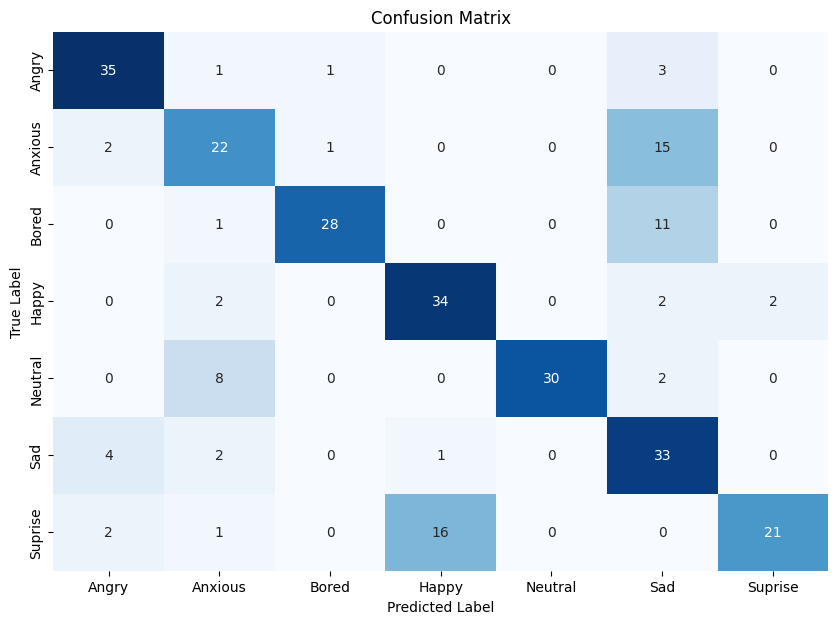

In [30]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load and process test data
df_test = pd.read_csv('validation.csv')
test_texts = df_test.iloc[:, 0].tolist()


# Evaluate the model
def evaluate_model(model, test_features):
    model.eval()
    with torch.no_grad():
        y_pred_logits = model(test_features)
        _, y_pred_classes = torch.max(y_pred_logits, 1)  # Get class with highest score
        return y_pred_classes.numpy()

# Get predictions
y_pred_classes = evaluate_model(model, X_val_tensor)

# True labels
y_true_classes = y_val_tensor.numpy()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Create a DataFrame for Seaborn
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=label_encoder.classes_,
                              columns=label_encoder.classes_)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Report

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       Angry       0.81      0.88      0.84        40
     Anxious       0.59      0.55      0.57        40
       Bored       0.93      0.70      0.80        40
       Happy       0.67      0.85      0.75        40
     Neutral       1.00      0.75      0.86        40
         Sad       0.50      0.82      0.62        40
     Suprise       0.91      0.53      0.67        40

    accuracy                           0.72       280
   macro avg       0.77      0.72      0.73       280
weighted avg       0.77      0.72      0.73       280



# Load in test dataset

In [ ]:
# Load and process test data
df_test = pd.read_csv('Test_onehot.csv')
test_texts = df_test.iloc[:, 0].tolist()

# Process test data
all_features_test = []
for text in test_texts:
    standardized_text = standardize_data(text)
    line = underthesea.word_tokenize(standardized_text, format="text")
    features, _ = process_long_sequence(line, max_len=500, chunk_size=256)
    all_features_test.append(features)

all_features_test = np.array(all_features_test)
X_test_features = all_features_test.reshape(all_features_test.shape[0], -1)
X_test_tensor = torch.tensor(X_test_features, dtype=torch.float32)

# Prepare test labels
raw_labels_test = df_test['Cảm xúc'].tolist()
label_encoder = LabelEncoder()
# Use the same encoder fitted on training data
y_labels_test = label_encoder.fit_transform(raw_labels_test)
y_test_tensor = torch.tensor(y_labels_test, dtype=torch.long)

# Evaluate the model
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        y_pred = model(test_features)
        _, predicted_classes = torch.max(y_pred, 1)  # Get class with highest score
        accuracy = (predicted_classes == test_labels).float().mean().item()
        print(f'Test Accuracy: {accuracy:.4f}')

evaluate_model(model, X_test_tensor, y_test_tensor)


In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load and process test data
df_test = pd.read_csv('Test_onehot.csv')
test_texts = df_test.iloc[:, 0].tolist()

# Process test data
all_features_test = []
for text in test_texts:
    standardized_text = standardize_data(text)
    line = underthesea.word_tokenize(standardized_text, format="text")
    features, _ = process_long_sequence(line, max_len=500, chunk_size=256)
    all_features_test.append(features)

all_features_test = np.array(all_features_test)
X_test_features = all_features_test.reshape(all_features_test.shape[0], -1)
X_test_tensor = torch.tensor(X_test_features, dtype=torch.float32)

# Prepare test labels
raw_labels_test = df_test['Cảm xúc'].tolist()
label_encoder = LabelEncoder()
y_labels_test = label_encoder.fit_transform(raw_labels_test)
y_test_tensor = torch.tensor(y_labels_test, dtype=torch.long)

# Evaluate the model
def evaluate_model(model, test_features):
    model.eval()
    with torch.no_grad():
        y_pred_logits = model(test_features)
        _, y_pred_classes = torch.max(y_pred_logits, 1)  # Get class with highest score
        return y_pred_classes.numpy()

# Get predictions
y_pred_classes = evaluate_model(model, X_test_tensor)

# True labels
y_true_classes = y_test_tensor.numpy()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Create a DataFrame for Seaborn
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=label_encoder.classes_,
                              columns=label_encoder.classes_)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Test with one data

In [ ]:
import torch
import numpy as np

# Assuming the model and tokenizer are already loaded

def predict_sentence(sentence, model, tokenizer, max_len=500, chunk_size=256):
    standardized_text = standardize_data(sentence)
    features, _ = process_long_sequence(standardized_text, max_len=max_len, chunk_size=chunk_size)


    # Flatten features and add batch dimension
    features = np.array(features)
    features = features.reshape(1, -1)  # Reshape to (1, input_dim) for a single sample
    X_tensor = torch.tensor(features, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        logits = model(X_tensor)
        proba = torch.softmax(logits, dim=1)

        # Get the predicted class
        predicted_label = torch.argmax(proba, dim=1).item()
        return proba.numpy(), predicted_label

sentence = '''
Hôm nay, tôi nghe tin cháu trai bị ngã khi chơi bóng đá ở trường. Nghe mà lòng tôi thắt lại. Con bé vừa gọi điện cho tôi, nói rằng cháu chỉ bị xây xát một chút, nhưng tôi không thể không lo lắng. Hình ảnh cháu nằm ở sân bóng, đau đớn và khóc lóc cứ hiện lên trong đầu tôi. Tôi biết trẻ con chơi thể thao thì không tránh khỏi bị thương, nhưng không hiểu sao lần này lại khiến tôi lo lắng đến vậy.

Mỗi khi nhận được tin tức từ trường, lòng tôi lại như lửa đốt. Tôi không thể ngừng suy nghĩ về những điều tồi tệ có thể xảy ra. Nếu cháu bị chấn thương nặng, không ai phát hiện kịp thời thì sao? Cảm giác bất lực cứ dâng trào, như có một tảng đá đè nặng lên ngực tôi. Ngồi uống trà mà lòng không yên, tôi cứ nghĩ đến cháu. Mới hôm qua còn cười đùa, giờ lại nằm ở bệnh viện, khiến tôi càng thêm hoang mang.

Tối nay, tôi đã đến trường để đón cháu. Nhìn thấy cháu bước ra, tay ôm băng trên đầu, tôi nhẹ nhõm hơn phần nào. Nhưng khi cháu nói: “Ông ơi, cháu không sao đâu!” thì tôi lại thấy lòng mình không thể yên ổn. Tôi chỉ muốn ôm chặt lấy cháu, hỏi han mọi chuyện, nhưng tôi biết cháu cần không gian riêng.

Càng nghĩ tôi càng thấy lo lắng, không biết liệu mình có đủ khả năng bảo vệ cho cháu không. Lần sau, tôi sẽ cố gắng dạy cháu phải cẩn thận hơn, nhưng cũng không thể ngăn nổi bản tính hiếu động của trẻ nhỏ. Mong rằng cháu sẽ luôn an toàn và không gặp phải những tai nạn như thế này nữa. Làm ông có những nỗi lo lắng thật khó tả, nhưng tôi chỉ cầu mong cháu sẽ luôn được khỏe mạnh, để tôi không phải sống trong sự hồi hộp như hôm nay nữa.
'''

proba, predicted_label = predict_sentence(sentence, model, v_tokenizer)

print(f"Probabilities for the sentence: {proba}")
print(f"Predicted label (index): {predicted_label}")

label_names = label_encoder.classes_  # Assuming you have label_encoder from before
print(f"Predicted class name: {label_names[predicted_label]}")

Probabilities for the sentence: [[0.0604398  0.67828447 0.13424557 0.0031102  0.01770995 0.04113298
  0.06507707]]
Predicted label (index): 1
Predicted class name: Anxious
